# Water Observations from Space (WOfS) for flow percentiles

This notebook creates an interactive flow duration curve. 

Daily streamflow information and gauge coordinates are retrieved directly from the Bureau of Meteorology (BoM) Hydrologic Reference Stations (HRS) website, http://www.bom.gov.au/water/hrs/.
The date of streamflow measurement and date of avaliable imagery are matched, for the location of the gauge. A flow duration cuve plot is created that enables the user to click on any percentage exceedance value and return the closest satellite image, for a small area surrounding the location stream gauge. Further, a larger image is then returned and there is an option to save imagery as a netcdf file.

In [1]:
#Import librarys 
%pylab notebook

import datacube 
from datacube import Datacube
from datacube.storage import masking
from datacube.storage.masking import mask_to_dict
from datacube.storage.storage import write_dataset_to_netcdf
from datacube.helpers import ga_pq_fuser

import xarray as xr
import pandas as pd
import numpy as np
import datetime
import csv
import os

from matplotlib.backends.backend_pdf import PdfPages
from matplotlib import pyplot as plt
import matplotlib.dates
from IPython.display import display
import ipywidgets as widgets

import rasterio
from pyproj import Proj, transform
import urllib
from dateutil import tz
from_zone = tz.tzutc()
to_zone = tz.tzlocal()
dc = datacube.Datacube(app='dc-show changes in annual mean NDVI values')
dcwofs = Datacube(config='/g/data/r78/ext547/wofscube.conf')

Populating the interactive namespace from numpy and matplotlib


## Retrieve stream data from the BoM website
Enter the stream gauge ID and retrieve daily stream flow and location information from the BoM website

In [2]:
#Insert the BoM ID code for the gauge of interest. e.g. for 'Diamantina River at Birdsville' the ID code is 'A0020101'
##USER INPUT - Gauge number
gauge_of_interest= '116006B'

In [3]:
#Url is used to retrieve to take our gauge of interest data     
url = 'http://www.bom.gov.au/water/hrs/content/data/'+gauge_of_interest+'/'+gauge_of_interest+'_daily_ts.csv'
#retrieve data from website and save as a variable called gauge data
gaugedata = pd.read_csv(url, comment='#')
print (gaugedata)

             Date  Flow (ML) Bureau QCode
0      1969-09-17    501.302            A
1      1969-09-18    487.811            A
2      1969-09-19    473.946            A
3      1969-09-20    439.312            A
4      1969-09-21    411.200            A
5      1969-09-22    394.272            A
6      1969-09-23    381.724            A
7      1969-09-24    367.365            A
8      1969-09-25    349.816            A
9      1969-09-26    334.918            A
10     1969-09-27    327.880            A
11     1969-09-28    327.790            A
12     1969-09-29    321.644            A
13     1969-09-30    303.017            A
14     1969-10-01    288.829            A
15     1969-10-02    280.317            A
16     1969-10-03    261.832            A
17     1969-10-04    253.342            A
18     1969-10-05    253.238            A
19     1969-10-06    253.238            A
20     1969-10-07    253.238            A
21     1969-10-08    253.238            A
22     1969-10-09    253.238      

In [4]:
# Search URL for stream gauge coordinates and convert into Australian Albers

#search url to find coordinates 
txt = urllib.request.urlopen(url).read()
txt = str(txt)
sg_lon = txt.split('"Location:", ')[1].split(',"degrees E",')[0]
sg_lon=float(sg_lon)
sg_lat = txt.split(',"degrees E", ')[1].split(',"degrees S"')[0]
sg_lat= "-"+sg_lat
sg_lat=float(sg_lat)

#reproject
inProj = Proj(init='EPSG:4326')
outProj = Proj(init='EPSG:3577')
sg_x,sg_y = transform(inProj,outProj,sg_lon,sg_lat)

print ("Geographic: " + str(sg_lon)+', '+ str(sg_lat))
print ("Australian Albers: "+ str(sg_x)+', '+str(sg_y))

Geographic: 145.9222, -18.4913
Australian Albers: 1465595.9604252446, -2056535.035993342


## Set up the Datacube query

In [5]:
#### DEFINE SPATIOTEMPORAL RANGE AND BANDS OF INTEREST

#Define temporal range
start_of_epoch = '1987-01-01'
#need a variable here that defines a rolling 'latest observation'
end_of_epoch =  '2014-12-31'

#Define wavelengths/bands of interest, remove this kwarg to retrieve all bands
bands_of_interest = [#'blue',
                     'green',
                     'red', 
                     'nir',
                     'swir1', 
                     #'swir2'
                     ]

#Define sensors of interest, # out sensors that aren't relevant for the time period
sensors = [
    'ls8', #May 2013 to present
    'ls7', #1999 to present
    'ls5' #1986 to 2011, full contintal coverage from 1987 onwards
        ] 


query = {
    'time': (start_of_epoch, end_of_epoch),
}

#create bounding box around the location of the stream gauge
lat_max = sg_lat + 0.01
lat_min = sg_lat - 0.01
lon_max = sg_lon + 0.01
lon_min = sg_lon - 0.01


query['x'] = (lon_min, lon_max)
query['y'] = (lat_max, lat_min)
query['crs'] = 'EPSG:4326'

In [6]:
#Define which pixel quality artefacts you want removed from the results
mask_components = {'cloud_acca':'no_cloud',
'cloud_shadow_acca' :'no_cloud_shadow',
'cloud_shadow_fmask' : 'no_cloud_shadow',
'cloud_fmask' :'no_cloud',
'blue_saturated' : False,
'green_saturated' : False,
'red_saturated' : False,
'nir_saturated' : False,
'swir1_saturated' : False,
'swir2_saturated' : False,
'contiguous':True}

## Datacube extraction
The extracted data is first filtered using the criteria in "mask_components".
The cloudyness of the scenes is then tested, and any scenes that do not meet the given "cloud_threshold" are discarded

In [7]:
#Retrieve the NBAR and PQ data for sensor n
sensor_clean = {}
##USER INPUT - Set cloud threshold value. Default is 0.99.
cloud_threshold = 0.90
for sensor in sensors:
    #Load the NBAR and corresponding PQ
    sensor_nbar = dc.load(product= sensor+'_nbar_albers', group_by='solar_day', measurements = bands_of_interest,  **query)
    sensor_pq = dc.load(product= sensor+'_pq_albers', group_by='solar_day', fuse_func=ga_pq_fuser, **query)
    
    #grab the projection info before masking/sorting
    crs = sensor_nbar.crs
    crswkt = sensor_nbar.crs.wkt
    affine = sensor_nbar.affine
    
    #This line is to make sure there's PQ to go with the NBAR
    sensor_nbar = sensor_nbar.sel(time = sensor_pq.time)
    
    #Apply the PQ masks to the NBAR
    quality_mask = masking.make_mask(sensor_pq, **mask_components)
    good_data = quality_mask.pixelquality.loc[start_of_epoch:end_of_epoch]
    sensor_nbar2 = sensor_nbar.where(good_data)
    
    # Calculate the percentage cloud free for each scene
    cloud_free = masking.make_mask(sensor_pq, cloud_acca='no_cloud', cloud_fmask='no_cloud', contiguous=True).pixelquality
    mostly_cloud_free = cloud_free.mean(dim=('x','y')) >= cloud_threshold
        
    # Throw away data that does not meet the cloud_threshold
    mostly_good = sensor_nbar2.where(mostly_cloud_free).dropna(dim='time', how='all')
    mostly_good['product'] = ('time', numpy.repeat(sensor, mostly_good.time.size))    
    sensor_clean[sensor] = mostly_good

    print('loaded %s' % sensor) 
    

print ('complete')

loaded ls8
loaded ls7
loaded ls5
complete


In [8]:
# Print output
sensor_clean

{'ls5': <xarray.Dataset>
 Dimensions:  (time: 161, x: 94, y: 98)
 Coordinates:
   * time     (time) datetime64[ns] 1987-07-19T23:42:03 ...
   * y        (y) float64 -2.055e+06 -2.055e+06 -2.055e+06 -2.055e+06 ...
   * x        (x) float64 1.464e+06 1.464e+06 1.464e+06 1.465e+06 1.465e+06 ...
 Data variables:
     green    (time, y, x) float64 901.0 846.0 846.0 846.0 846.0 846.0 846.0 ...
     red      (time, y, x) float64 1.132e+03 739.0 690.0 690.0 739.0 739.0 ...
     nir      (time, y, x) float64 2.701e+03 3.855e+03 4.085e+03 4.085e+03 ...
     swir1    (time, y, x) float64 3.146e+03 2.178e+03 2.093e+03 2.051e+03 ...
     product  (time) <U3 'ls5' 'ls5' 'ls5' 'ls5' 'ls5' 'ls5' 'ls5' 'ls5' ...
 Attributes:
     crs: EPSG:3577, 'ls7': <xarray.Dataset>
 Dimensions:  (time: 40, x: 94, y: 98)
 Coordinates:
   * time     (time) datetime64[ns] 1999-08-14T00:09:40.500000 ...
   * y        (y) float64 -2.055e+06 -2.055e+06 -2.055e+06 -2.055e+06 ...
   * x        (x) float64 1.464e+06 1.464e+

In [9]:
#Concatenate (join) data from the different landsat sensors together and sort so that observations 
#are sorted by time rather than sensor

nbar_clean = xr.concat(sensor_clean.values(), dim='time')
time_sorted = nbar_clean.time.argsort()
nbar_clean = nbar_clean.isel(time=time_sorted)
nbar_clean.attrs['crs'] = crs
nbar_clean.attrs['affin|e'] = affine

In [10]:
# Check the concatenation
nbar_clean

<xarray.Dataset>
Dimensions:  (time: 215, x: 94, y: 98)
Coordinates:
  * y        (y) float64 -2.055e+06 -2.055e+06 -2.055e+06 -2.055e+06 ...
  * x        (x) float64 1.464e+06 1.464e+06 1.464e+06 1.465e+06 1.465e+06 ...
  * time     (time) datetime64[ns] 1987-07-19T23:42:03 ...
Data variables:
    green    (time, y, x) float64 901.0 846.0 846.0 846.0 846.0 846.0 846.0 ...
    red      (time, y, x) float64 1.132e+03 739.0 690.0 690.0 739.0 739.0 ...
    nir      (time, y, x) float64 2.701e+03 3.855e+03 4.085e+03 4.085e+03 ...
    swir1    (time, y, x) float64 3.146e+03 2.178e+03 2.093e+03 2.051e+03 ...
    product  (time) <U3 'ls5' 'ls5' 'ls5' 'ls5' 'ls5' 'ls5' 'ls5' 'ls5' ...
Attributes:
    crs: EPSG:3577
    affin|e: | 25.00, 0.00, 1464425.00|
| 0.00,-25.00,-2055300.00|
| 0.00, 0.00, 1.00|

## Process stream gauge information
Calculate the percentiles of stream flow, and sort the dataframe according to date

In [11]:
#import streamflow data from the gauge of interest
all_data = gaugedata
all_data= all_data.rename(columns={'Flow (ML)':'flow', 'Date':'date'})
#sort data by flow
all_data = all_data.sort_values('flow', ascending=[False])
#create rank column and data
all_data['ranks'] = np.arange(len(all_data)) + 1
# calculate probability of each rank
all_data['perexc'] = 100*(all_data['ranks'])/(len(all_data)+1)
all_data= all_data.sort_values(['date'])
all_data=all_data.drop(all_data.columns[[2]], axis=1)
all_data['date']=pd.to_datetime(all_data['date'], format='%Y/%m/%d %H:%M:%S')
all_data.date = all_data.date.map(lambda t: t.strftime('%Y-%m-%d')) # convert to a str for the merge below

In [12]:
all_data

,date,flow,ranks,perexc
0,1969-09-17,501.302,12145,73.414737
1,1969-09-18,487.811,12250,74.049447
2,1969-09-19,473.946,12360,74.714381
3,1969-09-20,439.312,12676,76.624554
4,1969-09-21,411.200,12911,78.045095
5,1969-09-22,394.272,13055,78.915553
6,1969-09-23,381.724,13171,79.616756
7,1969-09-24,367.365,13294,80.360273
8,1969-09-25,349.816,13439,81.236777
9,1969-09-26,334.918,13564,81.992383


## Return just the time and sensor product information from the datacube extraction

In [13]:
product_time = nbar_clean[['time', 'product']].to_dataframe()
product_time.index = product_time.index + pd.Timedelta(hours=10) # Roughly convert to local time
product_time.index = product_time.index.map(lambda t: t.strftime('%Y-%m-%d')) # Remove Hours/Minutes Seconds by formatting into a string

## Find where both stream gauge data AND satellite information exists

In [14]:
subset_data = pd.merge(all_data, product_time, left_on= 'date', right_index=True, how='inner')

In [15]:
subset_data['date']=pd.to_datetime(subset_data['date'], format='%Y/%m/%d %H:%M:%S') # back to datetime format

# Create flow duration curve (FDC)

In [16]:
#Prepare datasets for FDC

#Preapre all data
sorted_a_flow=sorted(all_data.flow, reverse=True)
sorted_a_pe=sorted(all_data.perexc)

#Prepare the matched subset data
sorted_s_flow=sorted(subset_data.flow, reverse=True)
sorted_s_pe=sorted(subset_data.perexc)

<IPython.core.display.Javascript object>


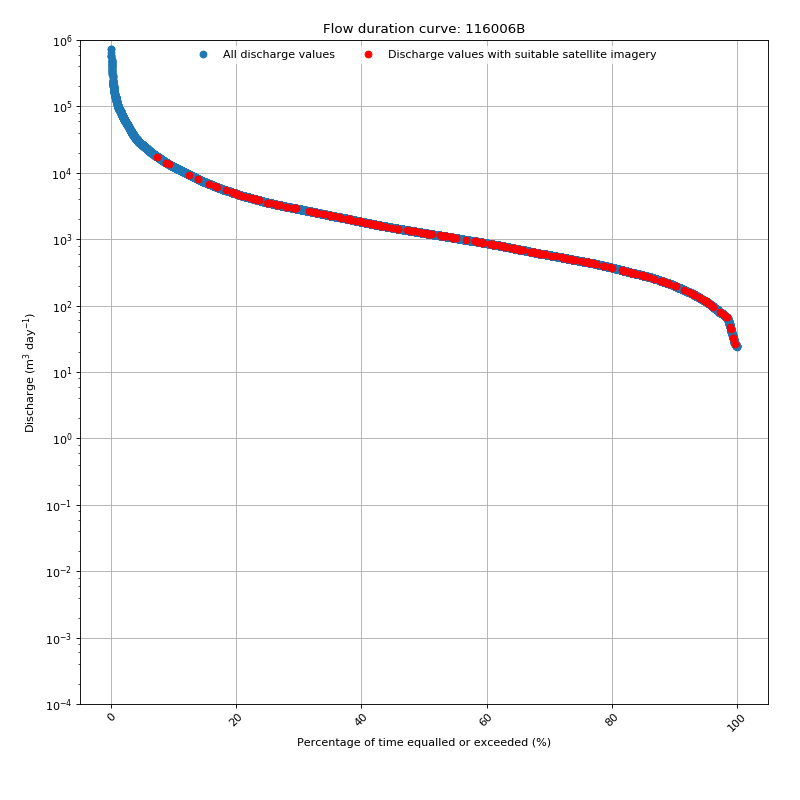

In [25]:
##create flow duration curve. Please note that this graph is not interactive

#Plot details
fig = plt.figure(figsize=(10,10))
plt.title('Flow duration curve: '+gauge_of_interest)

#create plot of percent exceedance
plt.plot(sorted_a_pe,sorted_a_flow,'o',label= 'All discharge values')
plt.plot(sorted_s_pe,sorted_s_flow,'ro',label='Discharge values with suitable satellite imagery')
plt.legend()
plt.grid(True)

#axis and legend details
plt.axis([-5, 105, 0.0001, 1000000])
plt.xticks(rotation=45,size=10)
plt.ylabel('Discharge (m$^3$ day$^{-1}$)')
plt.xlabel('Percentage of time equalled or exceeded (%)')
pyplot.yscale('log')
plt.legend(edgecolor ='none', ncol=2, loc=9)
plt.subplots_adjust(left=0.10, right=0.96, top=0.95, bottom=0.12)
fig.patch.set_facecolor('white')
fig.patch.set_alpha(0.99)


plt.show()

In [26]:
# #save figure
# %cd /g/data/r78/ext547/Output/FDC/
# plt.savefig('FDC_'+gauge_of_interest+'_10pct_CFI.jpg')

# Creation of wofs imagery

In [27]:
#### DEFINE AREA OF INTEREST FOR WOFS

#create a large bounding box around the location of the stream gauge
# lat_max = sg_lat + 0.6
# lat_min = sg_lat - 0.6
# lon_max = sg_lon + 0.8
# lon_min = sg_lon - 0.4

#create smaller bounding box around the location of the stream gauge
lat_max = sg_lat + 0.05
lat_min = sg_lat - 0.05
lon_max = sg_lon + 0.05
lon_min = sg_lon - 0.05


query['x'] = (lon_min, lon_max)
query['y'] = (lat_max, lat_min)
query['crs'] = 'EPSG:4326'

In [79]:
#set FDC threshold range
FDC_subset=subset_data[subset_data['perexc'].between(0, 100, inclusive=True)]

In [80]:
#create a query to store spatiotemporal information from the previous landsat query
wofs_query = query
#wofs_query['time'] = (FDC_subset.date.iloc[0]+ datetime.timedelta(days=-1)), (FDC_subset.date.iloc[0]+ datetime.timedelta(days=+1))#wofs_query

In [81]:
#Retrieve wofs data array for each date specified within the FDC threshold range #e.g. between 0-10% exceedance
#and save to an array

wofs_subset = {}
for i in range(len(FDC_subset)):
    wofs_query['time'] = (FDC_subset.date.iloc[i]), (FDC_subset.date.iloc[i]+ datetime.timedelta(days=+1))
    wofs_data = dcwofs.load(product = 'old_wofs', **wofs_query)
    wofs_subset[i]=wofs_data
print (wofs_subset)

{0: <xarray.Dataset>
Dimensions:  ()
Data variables:
    *empty*, 1: <xarray.Dataset>
Dimensions:  ()
Data variables:
    *empty*, 2: <xarray.Dataset>
Dimensions:  ()
Data variables:
    *empty*, 3: <xarray.Dataset>
Dimensions:  ()
Data variables:
    *empty*, 4: <xarray.Dataset>
Dimensions:  ()
Data variables:
    *empty*, 5: <xarray.Dataset>
Dimensions:  ()
Data variables:
    *empty*, 6: <xarray.Dataset>
Dimensions:  ()
Data variables:
    *empty*, 7: <xarray.Dataset>
Dimensions:  ()
Data variables:
    *empty*, 8: <xarray.Dataset>
Dimensions:  ()
Data variables:
    *empty*, 9: <xarray.Dataset>
Dimensions:  ()
Data variables:
    *empty*, 10: <xarray.Dataset>
Dimensions:  ()
Data variables:
    *empty*, 11: <xarray.Dataset>
Dimensions:  ()
Data variables:
    *empty*, 12: <xarray.Dataset>
Dimensions:  ()
Data variables:
    *empty*, 13: <xarray.Dataset>
Dimensions:  ()
Data variables:
    *empty*, 14: <xarray.Dataset>
Dimensions:  ()
Data variables:
    *empty*, 15: <xarray.Dataset

In [82]:
#
xr_wofs = xr.DataArray(wofs_subset)
list(wofs_subset.values())
wofs_subset2 = {k: x for (k, x) in wofs_subset.items() if x}
wofs_subset3=xr.concat(wofs_subset2.values(),dim='time')

In [83]:
#
wofs128=wofs_subset3
wofs128['water']=wofs_subset3.water.where(wofs_subset3.water==128)
wofs128.water

<xarray.DataArray 'water' (time: 92, latitude: 401, longitude: 401)>
array([[[ nan,  nan, ...,  nan,  nan],
        [ nan,  nan, ...,  nan,  nan],
        ..., 
        [ nan,  nan, ...,  nan,  nan],
        [ nan,  nan, ...,  nan,  nan]],

       [[ nan,  nan, ...,  nan,  nan],
        [ nan,  nan, ...,  nan,  nan],
        ..., 
        [ nan,  nan, ...,  nan,  nan],
        [ nan,  nan, ...,  nan,  nan]],

       ..., 
       [[ nan,  nan, ...,  nan,  nan],
        [ nan,  nan, ...,  nan,  nan],
        ..., 
        [ nan,  nan, ...,  nan,  nan],
        [ nan,  nan, ...,  nan,  nan]],

       [[ nan,  nan, ...,  nan,  nan],
        [ nan,  nan, ...,  nan,  nan],
        ..., 
        [ nan,  nan, ...,  nan,  nan],
        [ nan,  nan, ...,  nan,  nan]]])
Coordinates:
  * latitude   (latitude) float64 -18.44 -18.44 -18.44 -18.44 -18.44 -18.44 ...
  * longitude  (longitude) float64 145.9 145.9 145.9 145.9 145.9 145.9 145.9 ...
  * time       (time) datetime64[ns] 1999-08-14T00:09:05

In [84]:
wofs128.water.sum(dim = 'time')

<xarray.DataArray 'water' (latitude: 401, longitude: 401)>
array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])
Coordinates:
  * latitude   (latitude) float64 -18.44 -18.44 -18.44 -18.44 -18.44 -18.44 ...
  * longitude  (longitude) float64 145.9 145.9 145.9 145.9 145.9 145.9 145.9 ...

In [85]:
wofs128_v2 = (((wofs128.sum(dim = 'time')/128)/wofs128.time.count())*100)
wofs128_v2.water
#
#wofs128_v2 = (wofs128.sum(dim = 'time')/(int(wofs128.time.count())*128))
#wofs128_v2['water']

<xarray.DataArray 'water' (latitude: 401, longitude: 401)>
array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])
Coordinates:
  * latitude   (latitude) float64 -18.44 -18.44 -18.44 -18.44 -18.44 -18.44 ...
  * longitude  (longitude) float64 145.9 145.9 145.9 145.9 145.9 145.9 145.9 ...

In [86]:
#Sets up the WOfS colour ramp and corresponding thresholds
wofs_cmap = mpl.colors.ListedColormap(['#ffffcc', '#ffcc66','#3002d8'])
wofs_bounds = [0, 10, 90, 100]
wofs_norm = mpl.colors.BoundaryNorm(wofs_bounds, wofs_cmap.N)



# #This cell shows the x transect that you've chosen in the context of an NDVI image with a suitable colour ramp
# fig = plt.figure(figsize=(11.69,4))
# plt.plot([0, all_ndvi_sorted.shape[2]], [imagey,imagey], 'r')
# plt.imshow(all_ndvi_sorted.isel(time = time_slice_i), cmap = ndvi_cmap, norm = ndvi_norm)



<IPython.core.display.Javascript object>


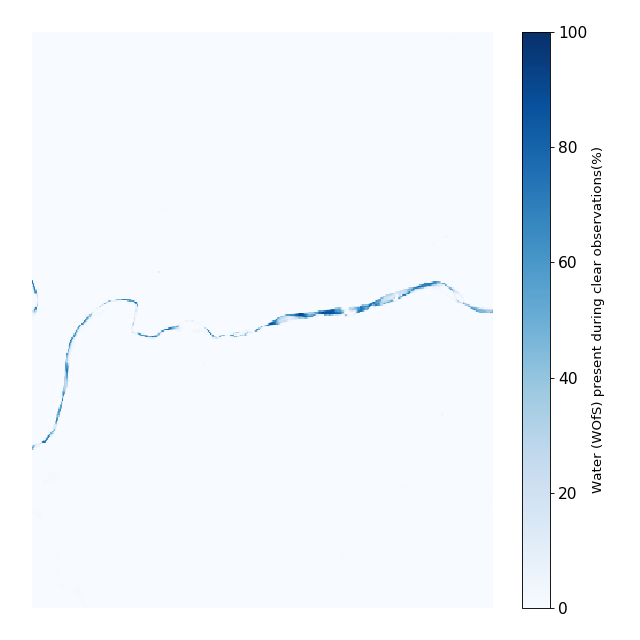

(145.87200000000001, 145.97225, -18.541500000000003, -18.44125)

In [87]:
#
fig = plt.figure(figsize =(8,8)) # set figure size
wofs128_v2.water.plot.imshow(cmap = 'Blues', vmin = 0, vmax = 100)#create plot
#fig.delaxes(fig.axes[1]) #remove colour bar 
fig.axes[1].tick_params(labelsize=14)
fig.axes[1].set_ylabel('Water (WOfS) present during clear observations(%)', size=12)

#reformat
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05) #set border size
fig.patch.set_facecolor('white') #ensure border is white
#fig.patch.set_alpha(0.99)
plt.axis('off')

In [ ]:
#save figure
%cd /g/data/r78/ext547/Output/wofs/FDC/
#plt.savefig('FDC_WOfS_10-20_large.jpg')
plt.savefig('FDC_WOfS_0-10_small_TEST.jpg')
#plt.savefig('colourbar.jpg')